In [2]:
import netCDF4 as nc
import scipy 
import os
import re
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import dask
from xmhw.xmhw import threshold, detect
from datetime import date
import cftime
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from scipy.optimize import curve_fit
import plotly.express as px
import plotly.graph_objects as go
import hashlib
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import glob
import math
import seaborn as sns
import cmcrameri.cm as cmc  # cmcrameri colormaps
import matplotlib.cm as cmm  # matplotlib colormaps
from pypalettes import load_cmap
from cmap import Colormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
from scipy.spatial import cKDTree
from timeit import default_timer as timer
def find_nearest_ocean_cell(lat, lon, dataset):
    """
    Improved method to find the nearest ocean cell for a given latitude and longitude using a KDTree for spatial search.
    
    Args:
    - lat (float): Latitude of the land coordinate.
    - lon (float): Longitude of the land coordinate.
    - dataset (xarray.Dataset): The dataset containing SST data.
    
    Returns:
    - (float, float): Latitude and longitude of the nearest ocean cell with valid SST data,
                      or (None, None) if no valid ocean cell is found.
    """
    # Ensure longitude is in the same format as the dataset
    if lon < 0:
        lon += 360
    
    # Flatten the lat/lon coordinates and create a KDTree for spatial search
    lats = dataset['lat'].values
    lons = dataset['lon'].values
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    valid_mask = np.isfinite(dataset['sst'].isel(time=0, zlev=0).values.ravel())  # Check first time and level
    valid_points = np.vstack([lat_grid.ravel()[valid_mask], lon_grid.ravel()[valid_mask]]).T
    tree = cKDTree(valid_points)

    # Find the nearest valid (ocean) cell
    distance, location = tree.query([lat, lon], k=1)  # k=1 for the nearest neighbor
    nearest_lat, nearest_lon = valid_points[location]

    return nearest_lat, nearest_lon

### New data (n/i + 1/2) for glm model prediction

#### Present-day urchin and max_intensity state (2023)

In [7]:
urchin_3d = pd.read_csv('3de_cr_ea_site.csv')

ku_concat_mhw = pd.read_csv('all_urchin_kelp_mhw.csv')
ku_concat_mhw = ku_concat_mhw[ku_concat_mhw.longitude > 140].reset_index(drop = True)
df_target_site = urchin_3d[urchin_3d.site_name.isin(ku_concat_mhw.site_name)].reset_index(drop=True)
df_target_site = df_target_site[['location', 'site_name', 'latitude', 'longitude', 'number']]

In [ ]:
ds = xr.open_dataset('OBIS_kelp_sst.nc')

df_climatmax = pd.DataFrame([])

for i, row in df_target_site.iterrows():
    location = row['location']
    # df_location = df_urchin_loc_site[(df_urchin_loc_site.location == location)].reset_index(drop=True)
    lat = row['latitude']
    lon = row['longitude']
    
    # select specific location
    # print('extracting sst...')
    ds_locat = ds.sel(lat = lat, lon = lon, method='nearest').squeeze('zlev', drop=True) #.mean(dim=("lat", "lon"))
    # Skip this iteration if the data is all NaNs
    if ds_locat.sst.isnull().all():     
        nearest_lat, nearest_lon = find_nearest_ocean_cell(lat, lon, ds)
        
        if nearest_lat is not None and nearest_lon is not None:
            ds_locat = ds.sel(lat = nearest_lat, lon = nearest_lon).squeeze('zlev', drop=True) #.mean(dim=("lat", "lon"))
        else:
            print(f"No valid ocean cell found for: {location}")
            continue  # Skip this location
    
    # print('calculating mhws...')
    clim = threshold(ds_locat.sst, pctile = 90, climatologyPeriod=[1991, 2020]) # threshold and climatology
    maxclim = float(clim.seas.max().values)  # Convert to float
    maxthresh = float(clim.thresh.max().values)
    # thresh90 = clim.thresh.where((clim.doy < 122) | (clim.doy > 335), drop=True).mean().values
    # seasonal50 = clim.seas.where((clim.doy < 122) | (clim.doy > 335), drop=True).mean().values
    
    ds_summer23 = ds_locat.sel(time = slice('2022-12-01','2023-04-30'))
    # summer_temp = ds_summer23.sst.mean(dim = 'time').values
    max_inten = (ds_summer23.sst - maxclim).max().values
    # accum_inten = (ds_summer23.sst - maxclim).where((ds_summer23.sst - maxclim)>0, 0).sum().values  

    df_var = pd.DataFrame({'max_inten' : [max_inten]})
    
    df_climatmax = pd.concat([df_climatmax, df_var])  
df_climatmax

In [13]:
df_input = pd.concat([df_target_site, df_climatmax.reset_index(drop=True)], axis=1)
df_input

,location,site_name,latitude,longitude,number,max_inten
0,Batemans,Acron Ledge,-35.72030,150.24789,0.715000,2.2939796447753906
1,Batemans,Barren Bommie,-36.13559,150.12916,2.630000,2.6457176208496094
2,Batemans,Belowla Island South West,-35.55425,150.38896,3.520000,2.2939796447753906
3,Batemans,Bingi Bingi Point,-36.01291,150.16603,0.160000,2.6457176208496094
4,Batemans,Bingi Bingi Point Nth,-36.01152,150.16517,0.030000,2.6457176208496094
...,...,...,...,...,...,...
119,Maria Island,Painted Cliffs,-42.59211,148.05035,0.023333,1.290151596069336
120,Maria Island,Painted Cliffs South (Four Mile Reef),-42.60250,148.04628,0.042381,1.290151596069336
121,Maria Island,Point Holme Lookout,-42.55305,147.94814,0.069074,1.290151596069336
122,Maria Island,Return Point,-42.62899,148.02431,0.020000,1.290151596069336


In [15]:
df_input.to_csv('glm_input2023.csv', index = False)

#### n+1/2 or max_intensity + 1/2 manually

In [ ]:
df_input = pd.read_csv('glm_input2023.csv')
df_input_new = df_input.copy()
df_input_new['max_inten'] = df_input_new['max_inten']+2  ## CHANGE this to adjust increase of number and max_inten
df_input_new['number'] = df_input_new['number']+1
df_input_new.head()

### Loaction different projections of GLM

In [8]:
inpath_2 = '/glm/output/i1n2/'
files_2 = glob.glob(inpath_2 + 'glmjb_intera_ni_dev_*.csv')

inpath_1 = '/glm/output/i2n1/'
files_1 = glob.glob(inpath_1 + 'glmjb_intera_ni_dev_*.csv')

inpath_3 = '/glm/output/withcmip/'
files_3 = glob.glob(inpath_3 + 'glmjb_intera_ni_dev_*_2090s_585.csv')

files_3

['/g/data/ng72/js5018/chapter3/modelling/glm/output/withcmip/glmjb_intera_ni_dev_ni_2090s_585.csv',
 '/g/data/ng72/js5018/chapter3/modelling/glm/output/withcmip/glmjb_intera_ni_dev_n_2090s_585.csv',
 '/g/data/ng72/js5018/chapter3/modelling/glm/output/withcmip/glmjb_intera_ni_dev_i_2090s_585.csv']

In [9]:
paths = {
    "i2n1": '/glm/output/i2n1/',
    "i1n2": '/glm/output/i1n2/',
    "withcmip": '/glm/output/withcmip/',
}

# Collect files from each path
files_dict = {group: glob.glob(path + 'glmjb_intera_ni_dev_*.csv') for group, path in paths.items()}

# Example loop to print or process each file
for group, files in files_dict.items():
    print(f"\n=== Processing group: {group} ===")
    
    df_merged = None
    for f in files:
        print(f"Processing: {f}")
        # Extract a label from the filename for naming
        label = f.split('_')[-3]  # e.g., 'n', 'i', 'in'

        glm_pred = pd.read_csv(f)

        df_pred_loc = glm_pred.groupby(["location"]).mean(numeric_only = True).reset_index(level=['location'])
        df_pred_loc = df_pred_loc.sort_values(by=['latitude'], ascending=False).reset_index(drop=True)

        # Rename the target column
        df_pred_loc = df_pred_loc[["location", "class_1_dev"]].rename(columns={"class_1_dev": f"class_1_dev_{label}"})

        # Drop duplicate 'location' cols to avoid merging issues
        if df_merged is None:
            df_merged = df_pred_loc
        else:
            df_merged = pd.merge(df_merged, df_pred_loc[['location', f"class_1_dev_{label}"]], on='location', how='left')
    
     # Dynamically assign to global variable like df_merged_i2n1, etc.
    globals()[f"df_merged_{group}"] = df_merged


=== Processing group: i2n1 ===
Processing: /g/data/ng72/js5018/chapter3/modelling/glm/output/i2n1/glmjb_intera_ni_dev_i_+2_.csv
Processing: /g/data/ng72/js5018/chapter3/modelling/glm/output/i2n1/glmjb_intera_ni_dev_ni_+1_+2.csv
Processing: /g/data/ng72/js5018/chapter3/modelling/glm/output/i2n1/glmjb_intera_ni_dev_n_+1_.csv

=== Processing group: i1n2 ===
Processing: /g/data/ng72/js5018/chapter3/modelling/glm/output/i1n2/glmjb_intera_ni_dev_ni_+2_+1.csv
Processing: /g/data/ng72/js5018/chapter3/modelling/glm/output/i1n2/glmjb_intera_ni_dev_i_+1_.csv
Processing: /g/data/ng72/js5018/chapter3/modelling/glm/output/i1n2/glmjb_intera_ni_dev_n_+2_.csv

=== Processing group: withcmip ===
Processing: /g/data/ng72/js5018/chapter3/modelling/glm/output/withcmip/glmjb_intera_ni_dev_ni_2090s_585.csv
Processing: /g/data/ng72/js5018/chapter3/modelling/glm/output/withcmip/glmjb_intera_ni_dev_n_2090s_585.csv
Processing: /g/data/ng72/js5018/chapter3/modelling/glm/output/withcmip/glmjb_intera_ni_dev_i_2090

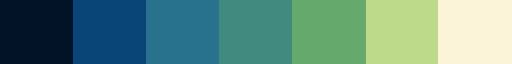

In [11]:
cmap = mcolors.ListedColormap(cmc.navia(np.linspace(0, 1, 7)))
cmap

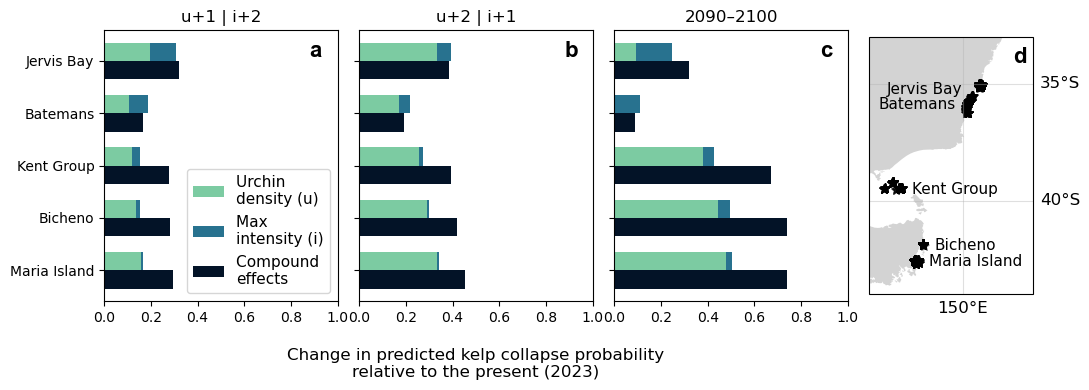

In [26]:
import string
locations = df_merged.location
y_axis = np.arange(len(locations)) 
height = 0.35
# cmap = load_cmap('Althoff')

fig = plt.figure(figsize=(11, 4))  # Slightly wider to fit 4 equal panels

# 4 equal-width subplots
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.7])  # No width_ratios specified
axs = [fig.add_subplot(gs[0, i]) for i in range(3)]

# Plot the bar charts in first 3 panels
for i, (group, path) in enumerate(paths.items()):
    df = globals()[f"df_merged_{group}"]
    ax = axs[i]
    bar1_left = ax.barh(y_axis - height/2, df.class_1_dev_n, height, label="Urchin \ndensity (u)", color=load_cmap('BluYl').colors[2])
    bar1_right = ax.barh(y_axis - height/2, df.class_1_dev_i, height, left=df.class_1_dev_n, label="Max \nintensity (i)", color= cmap.colors[2])
    bar2 = ax.barh(y_axis + height/2, df.class_1_dev_ni, height, label='Compound \neffects', color=cmap.colors[0])

    ax.invert_yaxis()
    ax.set_yticks(y_axis)
    ax.set_yticklabels('', rotation=0, fontsize=10)
    ax.set_xlim(0, 1)
    ax.text(0.88, 0.9, string.ascii_lowercase[i], transform=ax.transAxes, fontfamily='Arial',fontsize=16, weight='bold')
    
# Titles and labels
axs[0].legend(loc='lower right', fontsize=11)
axs[0].set_title('u+1 | i+2')
axs[1].set_title('u+2 | i+1')
axs[2].set_title('2090–2100')
axs[1].set_xlabel("\nChange in predicted kelp collapse probability\nrelative to the present (2023)", fontsize=12)
axs[0].set_yticklabels(df.location, rotation=0, fontsize=10)

# ====================== Map on 4th panel ====================================================================
rf_cv_site = pd.read_csv('/all_urchin_kelp_mhw.csv')
rf_cv_site= rf_cv_site[rf_cv_site.location.isin(locations)]
proj = ccrs.PlateCarree()
ax_map = fig.add_subplot(gs[0, 3], projection=proj)
axs.append(ax_map)
scatter = ax_map.scatter(np.array(rf_cv_site.longitude), np.array(rf_cv_site.latitude), 
                     c='k', marker='*', s=45, alpha = 0.5, transform=proj) # 

ax_map.add_feature(cfeature.LAND, facecolor='lightgrey')
ax_map.text(0.88, 0.9, 'd', transform=ax_map.transAxes, fontfamily='Arial',fontsize=16, weight='bold')

# Set the desired x and y range
lon_range = [146, 153]
lat_range = [-44, -33]
# Set the x and y axis limits
ax_map.set_xlim(lon_range)
ax_map.set_ylim(lat_range)
# Define the tick format functions
lat_formatter = mticker.FuncFormatter(lambda x, pos: '{:}°{}'.format(abs(x), 'S' if x < 0 else 'N'))
lon_formatter = mticker.FuncFormatter(lambda x, pos: '{:}°{}'.format(abs(x), 'W' if x < 0 else 'E'))

gl = ax_map.gridlines(draw_labels=True, alpha=0.4)
gl.right_labels = True      # ✅ show labels on the right
gl.left_labels = False      # ❌ hide labels on the left
gl.top_labels = False
gl.bottom_labels = True

# Set custom y-tick locations (latitudes)
gl.ylocator = mticker.FixedLocator(np.arange(-40, -25, 5))  # e.g., -40, -35, -30
gl.xlocator = mticker.FixedLocator(np.arange(145, 155, 5)) 
gl.xlabel_style = {'fontsize': 12}
gl.ylabel_style = {'fontsize': 12}
gl.yformatter = LATITUDE_FORMATTER
gl.xformatter = LONGITUDE_FORMATTER

for i, location in enumerate(locations):
    dfi = rf_cv_site[rf_cv_site.location == location]
    if location in ['Jervis Bay']:
        ax_map.text(dfi.longitude.iloc[0]-4, dfi.latitude.iloc[0]+0.2, dfi.location.iloc[0], transform=proj, 
            fontsize=11, va='top', ha='left')
    elif location in ['Maria Island', 'Bicheno']:  
        ax_map.text(dfi.longitude.iloc[0]+0.5, dfi.latitude.iloc[0]+0.3, dfi.location.iloc[0], transform=proj, 
            fontsize=11, va='top', ha='left')
    elif location in ['Kent Group']: 
        ax_map.text(dfi.longitude.iloc[0]+1.2, dfi.latitude.iloc[0]+0.3, dfi.location.iloc[0], transform=proj, 
            fontsize=11, va='top', ha='left')
    else:
        ax_map.text(dfi.longitude.iloc[0]-4, dfi.latitude.iloc[0], dfi.location.iloc[0], transform=proj, 
            fontsize=11, va='top', ha='left')

# Final layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
